In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
from shutil import copy2
import csv

In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [23]:
!pip install tensorflow_hub

In [24]:
import tensorflow_hub as hub

In [25]:
tf.__version__

'2.5.0'

In [26]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [27]:
data_root = ("/content/drive/My Drive/test/min")

In [28]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 284 images belonging to 5 classes.
Found 1142 images belonging to 5 classes.


In [29]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 5))

In [30]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Cheetos_McCombdalkom': 0, 'Jollypong': 1, 'Okssusukkang': 2, 'Pretzel': 3, 'null': 4}


In [31]:
!cat labels.txt

Cheetos_McCombdalkom
Jollypong
Okssusukkang
Pretzel
null

In [32]:
IMAGE_SIZE = 224

In [33]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [35]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [36]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=50,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/50
36/36 [==============================] - 270s 7s/step - loss: 0.5785 - acc: 0.8082 - val_loss: 0.1181 - val_acc: 1.0000
Epoch 2/50
36/36 [==============================] - 240s 7s/step - loss: 0.0750 - acc: 0.9930 - val_loss: 0.0482 - val_acc: 1.0000
Epoch 3/50
36/36 [==============================] - 238s 7s/step - loss: 0.0371 - acc: 0.9982 - val_loss: 0.0358 - val_acc: 1.0000
Epoch 4/50
36/36 [==============================] - 246s 7s/step - loss: 0.0259 - acc: 0.9982 - val_loss: 0.0257 - val_acc: 1.0000
Epoch 5/50
36/36 [==============================] - 238s 7s/step - loss: 0.0183 - acc: 0.9991 - val_loss: 0.0199 - val_acc: 1.0000
Epoch 6/50
36/36 [==============================] - 245s 7s/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 1.0000
Epoch 7/50
36/36 [==============================] - 238s 7s/step - loss: 0.0117 - acc: 0.9991 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 8/50
36/36 [==============================] - 243s 7s/step - loss: 0.0102 - a

In [37]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

9/9 [==============================] - 47s 5s/step - loss: 0.0014 - acc: 1.0000
Final loss: 0.00
Final accuracy: 100.00%


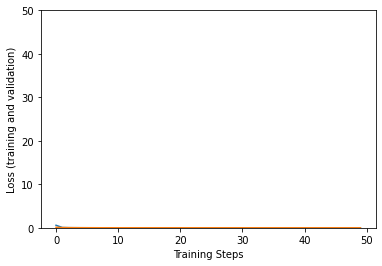

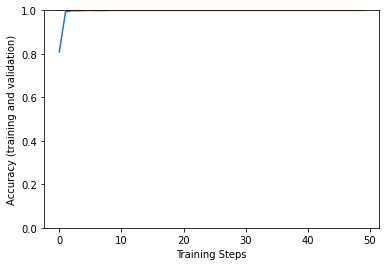

In [38]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [39]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [40]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cheetos_Mccombdalkom' 'Jollypong' 'Okssusukkang' 'Pretzel' 'Null']


In [41]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [42]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Null' 'Okssusukkang' 'Okssusukkang' 'Cheetos_Mccombdalkom' 'Null'
 'Okssusukkang' 'Pretzel' 'Pretzel' 'Null' 'Jollypong' 'Jollypong'
 'Okssusukkang' 'Null' 'Pretzel' 'Null' 'Pretzel' 'Pretzel' 'Pretzel'
 'Okssusukkang' 'Cheetos_Mccombdalkom' 'Null' 'Cheetos_Mccombdalkom'
 'Jollypong' 'Null' 'Jollypong' 'Pretzel' 'Cheetos_Mccombdalkom'
 'Cheetos_Mccombdalkom' 'Cheetos_Mccombdalkom' 'Cheetos_Mccombdalkom'
 'Null' 'Cheetos_Mccombdalkom']


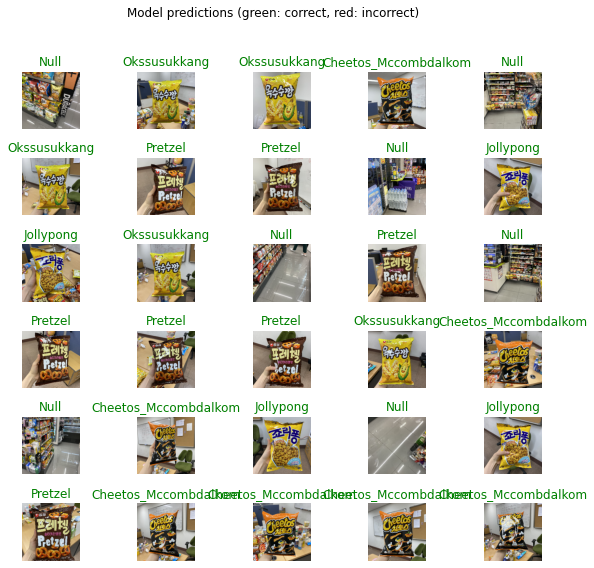

In [43]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [44]:
saved_model_dir = '/content'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets
